Version info
>v011 - deleted testing codes

Environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

import pymc3 as pm
import scipy.optimize as so

#from pymc3 import Model, sample, find_MAP, summary
#from pymc3 import NUTS, Metropolis, Slice
#from pymc3 import Normal, Uniform
#from scipy import optimize
#from pymc3 import traceplot

Using gpu device 0: GeForce GTX 750 (CNMeM is enabled)


In [2]:
debug = False

In [5]:
debug = True

Loading and preprocessing barley data(explatory variables)

In [3]:
#Loading data file
#barley_raw = pd.read_csv('./data/barley_01.csv', sep=',', header=0, index_col=0)
barley_raw = pd.read_table('./data/barley_01.txt', sep='\t', header=0, index_col=0)

#Explorering data
if debug:
    barley_raw.head()
    barley_raw.info()

#Transposing
barley_t = barley_raw.transpose()
if debug:
    print(barley_t.iloc[0:5, 0:5])

# 39, 96, 116, 103 th DH lines removed for marker mapping(146 marker mappings)
# and also 33 th DH line should be removed for QTL analysis(145 lines)
barley = barley_t.drop(labels=barley_t.index[[39-1, 96-1, 116-1, 103-1, 33-1]])

barley.head()

#Imputed missing(-) to 1 temporarily, I'll use automatic imputation feature of PyMC
#[http://stronginference.com/missing-data-imputation.html]
barley.replace(['A', 'B', '-'], [0,1,1], inplace=True)

if debug:
    print(barley.ix[:6,10:20])

Loading and preprocessing heading data(response variable)

In [4]:
heading_raw = pd.read_table('./data/HED_01.txt', sep='\t', header=0, index_col=0)
heading_raw.replace([-9999.0, -9999], [float('NaN'), float('NaN')], inplace=True)
if debug:
    print(heading_raw.head())
    
# Averaging 'days to heading' over all environments for each line.
heading = heading_raw.mean(skipna=True)
if debug:
    heading.head()



Testing with small dataset

Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta0
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta1
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta2
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to sigma_interval
 [-----------------100%-----------------] 1000 of 1000 complete in 19.1 sec
beta0:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  58.542           0.334            0.012            [57.891, 59.160]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  57.903         58.321         58.544         58.769         59.198


beta1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -13.501          71.261           6.026            [-145.057, 125.024]

  Posterior 

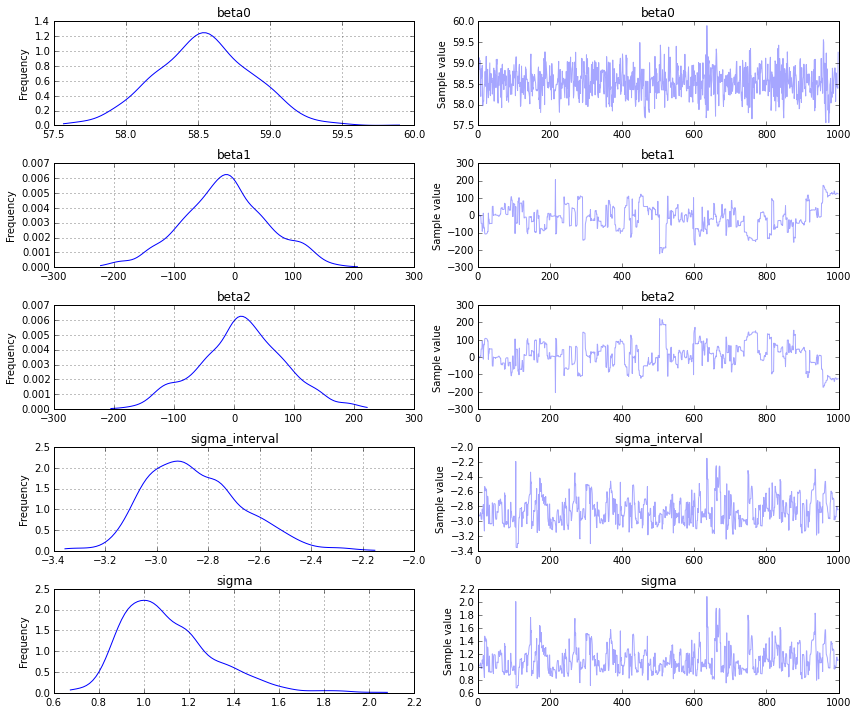

In [5]:
num_n = 20
num_p = 2
X = barley.ix[:num_n,:num_p]
Y = heading.ix[:num_n]

X.ix[:,0]

niter = 1000

basic_model = pm.Model()

with basic_model:
    # Priors
    beta0 = pm.Normal('beta0', mu=0, sd=100, shape=1)
    beta1 = pm.Normal('beta1', mu=0, sd=100, shape=1)
    beta2 = pm.Normal('beta2', mu=0, sd=100, shape=1)
    sigma = pm.Uniform('sigma', lower=0, upper=20)
    
    # 
    y_est = beta0 + beta1*X.ix[:,0] + beta2*X.ix[:,1]
    
    # 
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=Y)
    
    # inference
    start = pm.find_MAP()
    trace = pm.sample(niter, start=start, random_seed=2015, progressbar=True)
    pm.traceplot(trace)

pm.summary(trace)
